
### Hi... Frineds I tryed different types of NN based Models but no luck, then i read Web-Traffic-Implementation, The winner of this compitation provided code with good documentation, Then i decided to implement his idea for this competition.

### The solution of this competition in Tensorflow. Honestly i am not good with TF. Then i think can i implement this in Pytorch. Then i start reading his solution documentation and go through each and every line try to understand miss something again debug and google it try to implement those in Pytorch... It takes 1week to understand and implement model in pytorch.

### At last i got his flow and implemented his model in pytorch, When i did that i feel very happy.

### With is model i manage to get LB:0.58 

## Acknowledgements

1. [Web Traffic Time Series Forecasting](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)

2. [Web Traffic Time Series Forecasting 1st place solution](https://github.com/Arturus/kaggle-web-traffic)

3. [Encoder Decoder Pytorch](https://www.kaggle.com/gopidurgaprasad/m5-encoder-decoder-pytorch)

4. [EDA + LSTM Pytorch](https://www.kaggle.com/gopidurgaprasad/m5-forecasting-eda-lstm-pytorch-modeling)



## Problem Formulation

- State -> Store -> Category -> Depoartment -> Item
- Total Stores -> 10
- For one Store -> 3049
- For one Item -> 1913 days
- For one Item -> Category -> Deportment
-  We need to predict 28d "Demand" for every Item in Every Store

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import glob
from tqdm import tqdm_notebook as tqdm

import torch
import cv2
from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as pretrained_models
import os
#import pretrainedmodels
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import trange
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

### Utils

In [ ]:
## utils
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Data Preparation

In [ ]:
def find_start_end(data: np.ndarray):
    """
    Calculates start and end of real demand data. Start is an index of first non-zero and
    end index of non-zero

    :param data: Time series, shape [n_items, n_days]
    :return : start_idx, end_idx
    """

    n_items = data.shape[0]
    n_days = data.shape[1]
    
    start_idx = np.full(n_items, -1, dtype=np.int32)
    end_idx = np.full(n_items, -1, dtype=np.int32)

    for item in range(n_items):
        # scan from start to the end
        for day in range(n_days):
            if not np.isnan(data[item, day]) and data[item, day] > 0:
                start_idx[item] = day 
                break
        # reverse scan, from end to start
        for day in range(n_days - 1, -1, -1):
            if not np.isnan(data[item, day]) and data[item, day] > 0:
                end_idx[item] = day
                break

    return start_idx, end_idx

def read_x(df, start, end) -> pd.DataFrame:
    """
    Gets source data from start to end data, Any data can be None
    :param df -> dataframe
    :param start -> start day
    :param end -> end day

    :returns -> df 
    """
    if start and end:
        return df.loc[:, start:end]
    elif end:
        return df.loc[:, end]
    else:
        return df

def prepare_data(df , start, end, valid_threshold):
    """
    Reads source data, calculates start and end of each series, drops bad series, calculates log1p(demand)
    :param df
    :param start: start date of effective time interval, can be None to start from beginning
    :param end: end dae of effective time interval, can be None to return all data
    :param valid_threshold: minimal ratio of series real length to entire (end-start) interval.Series dropped if
    ratio is less then threshold
    :return: tuple(log1p(series), series start, series end)
    """

    df = read_x(df, start, end)
    starts, ends = find_start_end(df.values)

    # boolean mask for bad (too short) series
    page_mask = (ends - starts) / df.shape[1] < valid_threshold

    print("Masked %d pages from %d" % (page_mask.sum(), len(df)))
    inv_mask = ~page_mask
    df = df[inv_mask]
    
    return np.log1p(df), starts[inv_mask], ends[inv_mask]
    #return df, starts[inv_mask], ends[inv_mask]

def normalize(values: np.ndarray):
    return (values - values.mean()) / np.std(values)


def single_autocorr(series, lag):
    """
    Autocorrelation for single data series
    :param series: traffic series
    :param lag: lag, days
    :return:
    """
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

def batch_autocorr(data, lag, starts, ends, threshold, backoffset=0):
    """
    Calculate autocorrelation for batch (many time series at once)
    :param data: Time series, shape [n_pages, n_days]
    :param lag: Autocorrelation lag
    :param starts: Start index for each series
    :param ends: End index for each series
    :param threshold: Minimum support (ratio of time series length to lag) to calculate meaningful autocorrelation.
    :param backoffset: Offset from the series end, days.
    :return: autocorrelation, shape [n_series]. If series is too short (support less than threshold),
    autocorrelation value is NaN
    """
    n_series = data.shape[0]
    n_days = data.shape[1]
    max_end = n_days - backoffset
    corr = np.empty(n_series, dtype=np.float64)
    support = np.empty(n_series, dtype=np.float64)
    for i in range(n_series):
        series = data[i]
        end = min(ends[i], max_end)
        real_len = end - starts[i]
        support[i] = real_len/lag
        if support[i] > threshold:
            series = series[starts[i]:end]
            c_365 = single_autocorr(series, lag)
            c_364 = single_autocorr(series, lag-1)
            c_366 = single_autocorr(series, lag+1)
            # Average value between exact lag and two nearest neighborhs for smoothness
            corr[i] = 0.5 * c_365 + 0.25 * c_364 + 0.25 * c_366
        else:
            corr[i] = np.NaN
    return corr #, support

### Encode Id Features

- We have 10 Stores in each Store we have 3049 Itema os total items we need to encode is 10 * 3049 = 30490

- In web-traffic-implementation what he did was take each web-page and extract page features like (site, country, agent, etc) from urls then encoded as a page vector or think like embedding for page.

- Same idea i am following hear, total we have 30490 items each iteam have there categories like (item_id, dept_id, cat_id, store_id, state_id)

- From those categories we uniquely identify the items

In [ ]:
def encode_id_features(id_features):
    
    df = id_features.set_index("id")
    df["id"] = df.index.values

    #final_df = id

    #item_id
    item_id = pd.get_dummies(df["item_id"], drop_first=False, prefix="item_id")
    item_id = (item_id - item_id.mean()) / item_id.std()

    # dept_id
    dept_id = pd.get_dummies(df["dept_id"], drop_first=False, prefix="dept_id")
    dept_id = (dept_id - dept_id.mean()) / dept_id.std()

    # cat_id
    cat_id = pd.get_dummies(df["cat_id"], drop_first=False, prefix="cat_id")
    cat_id = (cat_id - cat_id.mean()) / cat_id.std()

    # store_id
    store_id = pd.get_dummies(df["store_id"], drop_first=False, prefix="store_id")
    store_id = (store_id - store_id.mean()) / store_id.std()

    # state_id
    state_id = pd.get_dummies(df["state_id"], drop_first=False, prefix="state_id")
    state_id = (state_id - state_id.mean()) / state_id.std()


    # encoded_id_df
    final_df = pd.merge(item_id,dept_id, how="left", left_index=True, right_index=True)
    final_df = pd.merge(final_df,cat_id, how="left", left_index=True, right_index=True)
    final_df = pd.merge(final_df,store_id, how="left", left_index=True, right_index=True)
    final_df = pd.merge(final_df,state_id, how="left", left_index=True, right_index=True)



    #print(f"item_id : {item_id.shape} , dept_id : {dept_id.shape} , cat_id : {cat_id.shape} , store_id : {store_id.shape}, state_id : {state_id.shape}")

    print(f"encoded_id_df : {final_df.shape}")

    return final_df

### Feature Engineering

- Demand : Raw values transformed by log1p() to get more-or-less normal intra-series values distribution, instead of skewed one.
- year-to-year autocorrelation, quarter-to-quarter autocorrelation - to capture yearly and quarterly seasonality strength.
- page popularity - High Demand and low Demand items have different demand change patterns, this feature (median of demand) helps to capture demand scale. This scale information is lost in a demand feature, because each demand series independently normalized to zero mean and unit variance.


In [ ]:
def create_seles_features(sales_df):

    id_features = sales_df[["id","item_id", "dept_id", "cat_id", "store_id","state_id"]]

    sales_df.drop(columns=["item_id", "dept_id", "cat_id", "store_id","state_id"],inplace=True)

    df = sales_df.set_index("id")

    df, starts, ends = prepare_data(df, start=None, end=None, valid_threshold=0.0)

    train_days_range = pd.date_range('29-01-2011',periods=1913)
    valid_days_range = pd.date_range('25-04-2016',periods=28)
    test_days_range = pd.date_range('23-05-2016',periods=28)

    df.columns = df.columns.to_series().apply(lambda x: int(x.split("_")[-1]))

    date_start, date_end = train_days_range[0] , train_days_range[-1]
    features_end = valid_days_range[-1]

    print(f"date_satart : {date_start} , date_end : {date_end}, features_end : {features_end}")
    
    encoded_id_features = encode_id_features(id_features)

    item_popularity = df.median(axis=1)
    item_popularity = (item_popularity - item_popularity.mean()) / item_popularity.std()

    # Yearly(annual) autocorrelation
    raw_year_autocorr = batch_autocorr(df.values, 365, starts, ends, 1.5, 0)
    year_unknown_pct = np.sum(np.isnan(raw_year_autocorr))/len(raw_year_autocorr)
    # Normalise all the things
    year_autocorr = normalize(np.nan_to_num(raw_year_autocorr))

    # Quarterly autocorrelation
    raw_quarter_autocorr = batch_autocorr(df.values, int(round(365.25/4)), starts, ends, 2, 0)
    quarter_unknown_pct = np.sum(np.isnan(raw_quarter_autocorr)) / len(raw_quarter_autocorr)  # type: float
    # Normalise all the things
    quarter_autocorr = normalize(np.nan_to_num(raw_quarter_autocorr))

    # Monthly autocorrelation
    raw_month_autocorr = batch_autocorr(df.values, int(round(30)), starts, ends, 2, 0)
    month_unknown_pct = np.sum(np.isnan(raw_month_autocorr)) / len(raw_month_autocorr)  # type: float
    # Normalise all the things
    month_autocorr = normalize(np.nan_to_num(raw_month_autocorr))

    # Weekly autocorrelation
    raw_week_autocorr = batch_autocorr(df.values, int(round(7)), starts, ends, 2, 0)
    week_unknown_pct = np.sum(np.isnan(raw_week_autocorr)) / len(raw_week_autocorr)  # type: float
    # Normalise all the things
    week_autocorr = normalize(np.nan_to_num(raw_week_autocorr))

    print("Percent of undefined autocorr = yearly:%.3f, quarterly:%.3f" % (year_unknown_pct, quarter_unknown_pct))

    final_df = pd.DataFrame({
        "item_popularity" : item_popularity,
        "year_autocorr" : year_autocorr,
        "quarter_autocorr": quarter_autocorr,
        "month_autocorr" : month_autocorr,
        "week_autocorr" : week_autocorr
    })

    final_df.index = df.index.values

    final_df = pd.merge(final_df,encoded_id_features, how="left", left_index=True, right_index=True)

    print("id_features : ", final_df.shape)

    extra_features = {
        "train_days_range": train_days_range,
        "valid_days_range": valid_days_range,
        "test_days_range": test_days_range,
        "starts" : starts,
        "ends" : ends
    }
    
    return final_df, df, extra_features

In [ ]:
%%time
sales_train_validation = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv")
sales_train_validation = reduce_mem_usage(sales_train_validation)
id_features_df, demand_df, extra_features_dict = create_seles_features(sales_train_validation)

### Calender Features

In [ ]:
def create_date_features(df):
    
    df["date"] = pd.to_datetime(df["date"])

    #df.set_index("date", inplace=True)

    # week day
    week_period = 7 / (2 * np.pi)
    dow_norm = df["wday"].values / week_period
    wday_cos = np.cos(dow_norm)
    wday_sin = np.sin(dow_norm)
    
    
    # month
    month_period = 12 / (2 * np.pi)
    dow_norm = df["month"].values / month_period
    month_cos = np.cos(dow_norm)
    month_sin = np.sin(dow_norm)

    #print(df["date"])

    # day
    day_period = 31 / (2 * np.pi)
    dow_norm = df["date"].dt.day / day_period
    day_cos = np.cos(dow_norm)
    day_sin = np.sin(dow_norm)
    

    # month
    #month = pd.get_dummies(df["month"], drop_first=False, prefix="month")
    #month = (month - month.mean()) / month.std()

    # day
    #day = pd.get_dummies(df["date"].dt.day, drop_first=False, prefix="date")
    #day = (day - day.mean()) / day.std()


    # event_name_1
    event_name_1 = pd.get_dummies(df["event_name_1"], drop_first=False, dummy_na=True, prefix="event_name_1")
    event_name_1 = (event_name_1 - event_name_1.mean()) / event_name_1.std()

    # event_type_1
    event_type_1 = pd.get_dummies(df["event_type_1"], drop_first=False, dummy_na=True, prefix="event_type_1")
    event_type_1 = (event_type_1 - event_type_1.mean()) / event_type_1.std()

    # event_name_2
    event_name_2 = pd.get_dummies(df["event_name_2"], drop_first=False, dummy_na=True, prefix="event_name_2")
    event_name_2 = (event_name_2 - event_name_2.mean()) / event_name_2.std()

    # event_type_2
    event_type_2 = pd.get_dummies(df["event_type_2"], drop_first=False, dummy_na=True, prefix="event_type_2")
    event_type_2 = (event_type_2 - event_type_2.mean()) / event_type_2.std()

    snap_CA = df["snap_CA"].values
    snap_TX = df["snap_TX"].values
    snap_WI = df["snap_WI"].values

    final_df = pd.DataFrame({
        "date":df["date"],
        "wday_cos": wday_cos,
        "wday_sin": wday_sin,
        "month_cos": month_cos,
        "month_sin": month_sin,
        "day_cos": day_cos,
        "day_sin": day_sin,
        "snap_CA": snap_CA,
        "snap_TX": snap_TX,
        "snap_WI": snap_WI
    })

    #final_df = pd.merge(final_df,month, how="left", left_index=True, right_index=True)
    #final_df = pd.merge(final_df,day, how="left", left_index=True, right_index=True)
    final_df = pd.merge(final_df,event_name_1, how="left", left_index=True, right_index=True)
    final_df = pd.merge(final_df,event_type_1, how="left", left_index=True, right_index=True)
    final_df = pd.merge(final_df,event_name_2, how="left", left_index=True, right_index=True)
    final_df = pd.merge(final_df,event_type_2, how="left", left_index=True, right_index=True)
    
    final_df.set_index("date", inplace=True)
    #dow = np.stack([wday_cos, wday_sin, month_cos, month_sin, day_cos, day_sin, snap_CA, snap_TX, snap_WI], axis=-1)

    return final_df

In [ ]:
%%time
calendar = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv")
calendar = reduce_mem_usage(calendar)
calendar_features_df = create_date_features(calendar)

### Lag Features

- Calculates indexes fro 1, 3, 6, 9, 12 months backward lag for the given date range

In [ ]:
def lag_indexes(begin, end):
    """
    Calculates indexes for 3, 6, 9, 12 months backward lag for the given date range
    :param begin: start of date range
    :param end: end of date range
    :return : List of 4 Series, one for each lag. For each Series, index is date in range(begin, end),value is an index
    of target (lagged) date in a same Series. If target date is out of (begin, end) range, index is -1
    """

    dr = pd.date_range(begin, end)

    #key is date, value is day index
    base_index = pd.Series(np.arange(0, len(dr)), index=dr)

    def lag(offset):
        dates = dr - offset

        date_lag = []
        for d in dates:
            if d in base_index.index:
                date_lag.append(base_index.loc[d])
            else:
                date_lag.append(-1)
        return pd.Series(data=np.array(date_lag).astype(np.int16), index=dr)
    
    return [lag(pd.DateOffset(months=m)) for m in (1, 3, 6, 9, 12)]

In [ ]:
lag_idx = lag_indexes('2011-01-29', '2016-05-22')

lag_idx_df = pd.DataFrame({
    "month_1": lag_idx[0],
    "month_3": lag_idx[1],
    "month_6": lag_idx[2],
    "month_9": lag_idx[3],
    "month_12": lag_idx[4],
})
lag_index = lag_idx_df.values

In [ ]:
id_features_df.shape, demand_df.shape, calendar_features_df.shape

### Find Start Index

- Calculates start of real demand data. Start is an index of first non-zero and end index of non-zero

In [ ]:
def fill_nan_before_starts(data: np.ndarray, starts):

    n_items = data.shape[0]
    n_days = data.shape[1]
    
    new_data = data.copy()

    for item in range(n_items):
        data[item, 0:starts[item]] = -1
    
    return data

demand_original = fill_nan_before_starts(demand_df.values, extra_features_dict["starts"])

### dataframe convert to Pytorch tensors

In [ ]:
def convert_pytorch_tensors(df):
    df_tensor = torch.tensor(df.values)
    df_indexs = df.index.values
    return df_tensor, df_indexs

id_tensor, id_idx = convert_pytorch_tensors(id_features_df)
demand_tensor, demand_idx = convert_pytorch_tensors(demand_df)
calender_tensor, calender_idx = convert_pytorch_tensors(calendar_features_df)

### Dataset for Pytorch Data Loaders

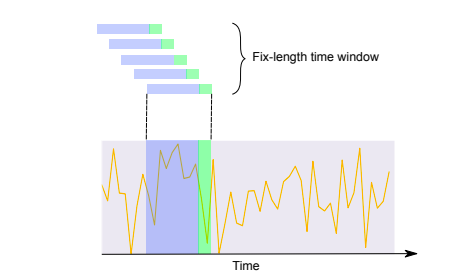

- we are using sliding window for model training
- we need to create train & valid & test dataset for model training
- the idea to load data using pytorch data loaders like this
    - we have 30490 items each item contain 1913 days of demand

In [ ]:
# make train data set for pytorch data loaders
train_df = pd.DataFrame(demand_original, columns = np.arange(1, 1914))
train_df["id"] = id_idx
train_df["id_index"] = np.arange(len(id_idx))
train_df = pd.melt(train_df, id_vars=["id", "id_index"], value_name="demand", var_name="day")
train_df = train_df[train_df.demand >= 0]

### Train & Valid & Test split

- Using last one year for traing
- and using sliding window for train data
- for simple i am taking last one year of demand

In [ ]:
train_days = np.arange(1856, (1856 - 366), -28)
valid_days_df = train_df[train_df.day == 1885]
train_days_df = train_df[train_df.day.isin(train_days)]

In [ ]:
train_days_df

- we can see train_days_df each id have starting day 1492

### Create DataLoader

- every time using indexs of item and indexs of day we are taking train window and predict widow data

In [ ]:
class M5Dataset:

    def __init__(self, df, hparams):
        
        self.id = df.id.values
        self.id_index = df.id_index.values
        self.day = df.day.values

        self.train_window = hparams["train_window"]
        self.predict_window = hparams["predict_window"]
        

    def __len__(self):
        return len(self.id)

    def __getitem__(self, item):

        id = self.id[item]
        id_index = self.id_index[item]
        day = self.day[item]-1 # because day index starts from 1

        id_features = id_tensor[id_index].unsqueeze(0)

        # train_x
        calendar_train = calender_tensor[day-self.train_window:day, :]
        id_train = torch.repeat_interleave(id_features, repeats=self.train_window, dim=0)
        
        demand_train = demand_tensor[id_index, day-self.train_window:day]
        lag_index_train = lag_index[day-self.train_window:day]
        lag_train = demand_tensor[id_index, lag_index_train]

        mean = torch.mean(demand_train)
        std = torch.std(demand_train)

        norm_demand_train = ((demand_train - mean) / std ) if std !=0 else demand_train
        norm_lag_train = (lag_train - mean) / std if std !=0 else lag_train
        
        # fingerprint
        fingerprint = torch.cat([norm_demand_train.unsqueeze(1), norm_lag_train], dim=1)
        
        
        train_x = torch.cat([id_train, calendar_train, fingerprint.double()], dim=1)
        
        
        # train_y
        calendar_predict = calender_tensor[day:day+self.predict_window, :]
        id_predict = torch.repeat_interleave(id_features, repeats=self.predict_window, dim=0)
        
        demand_predict = demand_tensor[id_index, day:day+self.predict_window]
        norm_demand_predict = (demand_predict - mean) / std
        
        lag_index_predict = lag_index[day:day+self.predict_window]
        lag_predict = demand_tensor[id_index, lag_index_predict]
        norm_lag_predict = (lag_predict - mean) / std if std !=0 else lag_predict
        
        train_y = torch.cat([id_predict, calendar_predict, norm_lag_predict.double()], dim=1)
        

        return {
            "encoder_input":train_x,
            "fingerprint":fingerprint,
            "previous_y":norm_demand_train,
            "decoder_input":train_y,
            "prediction_demand" : demand_predict,
            "mean":mean,
            "std":std
        }

In [ ]:
# Example

hparams = {
    "train_window":100,
    "predict_window":28
}

m5d = M5Dataset(valid_days_df,hparams)

In [ ]:
out = m5d.__getitem__(1)

out["encoder_input"].shape, out["decoder_input"].shape , out["prediction_demand"].shape, out["fingerprint"].shape

### Encoder Decoder Model

- Model has two main parts: encoder and decoder.


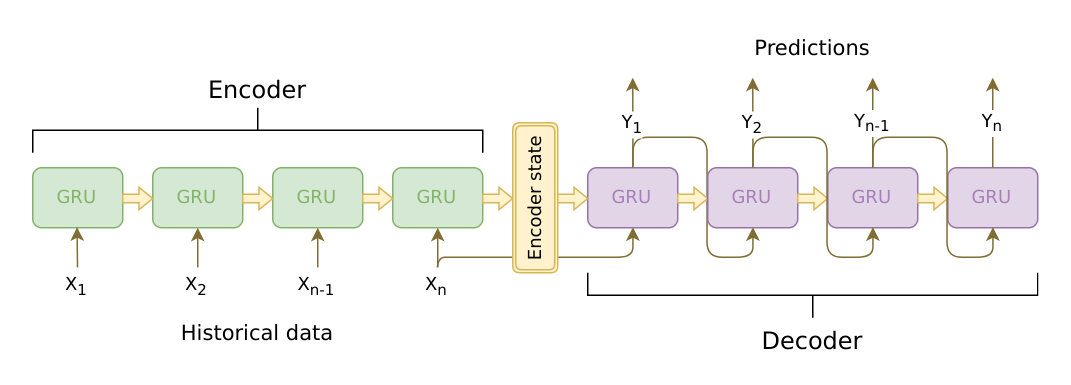

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hparams):
        super(Encoder, self).__init__()

        #print(hparams["encoder_input_size"])

        self.RNN = nn.RNN(
                    input_size=hparams["encoder_input_size"],
                    hidden_size=hparams["encoder_hidden_size"], 
                    num_layers=hparams["encoder_rnn_layers"],
                    batch_first=True,
                    #dropout = hparams["encoder_dropout"] if hparams["encoder_dropout"] else 0
                )
        
        self.compressed_readout = nn.Linear(hparams["encoder_hidden_size"], hparams["attention_depth"])
        
        
    def forward(self, X):
        
        rnn_out, rnn_state = self.RNN(X)

        encoder_state = rnn_state.squeeze(0)

        encoder_readout = F.selu(self.compressed_readout(rnn_out))

        return rnn_out, rnn_state, encoder_readout

def convert_cudnn_state_v2(h_state, hparams,c_state=None, dropout=1.0):
    """
    Converts RNN state tensor from cuDNN representation to TF RNNCell compatible representation.
    :param h_state: tensor [num_layers, batch_size, depth]
    :param c_state: LSTM additional state, should be same shape as h_state
    :return: TF cell representation matching RNNCell.state_size structure for compatible cell
    """
    def squeeze(seq):
        return tuple(seq) if len(seq) > 1 else seq[0]

    # cases:
    # decoder_layer = encoder_layers, straight mapping
    # encoder_layers > decoder_layers : get outputs of upper encoder layers
    # encoder_layers < deocder_layers : feed encoder outputs to lower decoder layers, feed zeros to top layers

    h_layers = torch.unbind(h_state)

    if hparams["encoder_rnn_layers"] >= hparams["decoder_rnn_layers"]:
        return squeeze(h_layers[hparams["encoder_rnn_layers"] - hparams["decoder_rnn_layers"]:])
    else:
        lower_inputs = [h_layers]
        upper_inputs = [torch.zeros_like(h_layers[0]) for _ in
                        range(hparams["decoder_rnn_layers"] - hparams["encoder_rnn_layers"])]
        #print(len(lower_inputs))
        #print(upper_inputs)
        return squeeze(lower_inputs + upper_inputs)

class FingerPrint(nn.Module):
    def __init__(self, hparams):
        super(FingerPrint, self).__init__()

        #print(hparams["fingerprint_in_channels"])

        self.c11 = nn.Conv1d(in_channels=hparams["fingerprint_in_channels"] ,out_channels=16,kernel_size=7, padding=7//2)
        self.c12 = nn.Conv1d(in_channels=16,out_channels=16, kernel_size=3, padding=3//2)
        self.pool1 = nn.MaxPool1d(2, 2)

        self.c21 = nn.Conv1d(in_channels=16,out_channels=32,kernel_size=3, padding=3//2)
        self.c22 = nn.Conv1d(in_channels=32,out_channels=32,kernel_size=3, padding=3//2)
        self.pool2 = nn.MaxPool1d(2, 2)

        self.c31 = nn.Conv1d(in_channels=32,out_channels=64,kernel_size=3, padding=3//2)
        self.c32 = nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3, padding=3//2)
        self.pool3 = nn.MaxPool1d(2, 2)

        self.fc_1 = nn.Linear(in_features=hparams["fingerprint_fc1_in_features"], out_features=512)
        self.fc_2 = nn.Linear(in_features=512, out_features=hparams["fingerprint_fc2_out_features"])

    def forward(self,x):
        # x -> [bs, time, features] -> [bs, features, time]
        x = x.transpose(2,1)

        x = F.relu(self.c11(x))
        x = F.relu(self.c12(x))
        x = self.pool1(x)

        x = F.relu(self.c21(x))
        x = F.relu(self.c22(x))
        x = self.pool2(x)

        x = F.relu(self.c31(x))
        x = F.relu(self.c32(x))
        x = self.pool3(x)

        dims = x.shape

        x = x.reshape(-1, dims[1] * dims[2])

        x = F.selu(self.fc_1(x))

        out_encoder = F.selu(self.fc_2(x))

        return out_encoder


class AttnReadOut(nn.Module):
    def __init__(self, hparams):
        super(AttnReadOut, self).__init__()

        self.hparams = hparams

        self.att_focus = nn.Linear(hparams["fingerprint_fc2_out_features"], 
                                   hparams["attn_window"] * hparams["attn_heads"])
    
    def forward(self, enc_readout, fingerprint):
        # enc_readout : [bs, time, att_f]
        # fingerprint : [bs, features]

        # en_readout : [bs, time, features] -> [attn_f, time, bs]
        enc_readout = enc_readout.transpose(2,0)

        # [batch(readout_depth), width, channels] -> [batch, height=1, width, channels]
        inp = enc_readout.unsqueeze(1)


        # attn_window = train_window - predict_window + 1
        # [batch, attn_window * n_heads]
        filter_logits = self.att_focus(fingerprint)

        # [batch, attn_window * n_heads] -> [batch, attn_window, n_heads]
        filter_logits = filter_logits.reshape(-1, self.hparams["attn_window"], self.hparams["attn_heads"])

        attns_max = filter_logits / filter_logits.sum(dim=1, keepdim=True)
        # [batch, attn_window, n_heads] -> [width(attn_window), channels(batch), n_heads]
        attns_max = attns_max.transpose(1,0)

        # [width(attn_window), channels(batch), n_heads] -> [height(1), widht(attn_windw), channels(batch), multiplier(n_heads)]
        attn_filter = attns_max.unsqueeze(0)

        # [bs, H, W, chanels] -> [bs, in_c, H, W]
        inp = inp.permute(0, 3, 1, 2)
        # [out_channels, in_channels/groups, H, W] -> [H, W, C, n_heads]
        attn_filter = attn_filter.permute(2, 3, 0, 1)

        cin = inp.shape[1]

        # [batch(readout_depth), height=1, widht=n_days, channels=batch] -> [batch(readout_depth), height=1, widht=predict_window, channels=batch*n_heads]
        averaged = F.conv2d(inp, attn_filter, padding=0, groups=cin)

        # [batch, channels=readout_depth*n_neads, height=1, width=predict_window] -> [batch, height=1, width=predict_window,channels=readout_depth*n_neads,]
        averaged = averaged.permute(0, 2, 3, 1)
        
        # [batch, height=1, width=predict_window, channels=readout_depth*n_neads] -> [batch(depth), predict_window, batch*n_heads]
        attn_features = averaged.squeeze(1)

        # [batch(depth), predict_window, batch*n_heads] -> [batch*n_heads, predict_window, depth]
        attn_features = attn_features.permute(2, 1, 0)

        # [batch * n_heads, predict_window, depth] -> n_heads * [batch, predict_window, depth]
        heads = [attn_features[head_no::self.hparams["attn_heads"]] for head_no in range(self.hparams["attn_heads"])]

        # n_heads * [batch, predict_window, depth] -> [batch, predict_window, depth*n_heads]
        result = torch.cat(heads, dim=-1)

        # attn_diag = torch.unstack(attns_max, dim=-1)

        return result, None

class Decoder(nn.Module):
    def __init__(self, hparams):
        super(Decoder, self).__init__()

        self.hparams = hparams
        
        if hparams["decoder_rnn_layers"] > 1:
            pass
        else:
            self.cell = nn.GRUCell(input_size=hparams["decoder_input_size"],
                              hidden_size=hparams["decoder_hidden_size"]
                              )
            
        self.projected_output = nn.Linear(in_features=hparams["decoder_fc_in_features"], out_features=1)

    

    def forward(self, encoder_state, attn_features, prediction_inputs, previous_y):
        
        predict_days = self.hparams["predict_window"]

        # [batch_size, time, input_depth] -> [time, batch_size, input_depth]
        inputs_by_time = prediction_inputs.permute(1,0,2)

        # Return raw outputs for RNN loss calcula
        targets_ta = []
        outputs_ta = []

        #print(previous_y.shape)
        prev_output = previous_y.unsqueeze(-1)

        prev_state = encoder_state

        for time in range(inputs_by_time.shape[0]):
            
            # RNN inputs for current step
            features = inputs_by_time[time]

            # [batch, predict_window, readout_depth * n_heads] -> [batch, readout_depth * n_heads]
            if attn_features is not None:
                # [batch_size, 1] + [batch_size,  input_depth]
                attn = attn_features[:, time, :]
                # Append previous predicted value + attention vector to input features
                #print(attn.shape)
                #print(prev_output.shape)
                #print(features.shape)
                next_input = torch.cat([prev_output, features, attn], dim=1)
            else:
                # append previous predicted values to input features
                next_input = torch.cat([prev_output, features], dim=1)
        
            # Run RNN cell
            #print(next_input.shape)
            output = self.cell(next_input, prev_state)

            # Make prediction from RNN outputs
            projected_output = self.projected_output(output)

            targets_ta.append(projected_output)
            outputs_ta.append(output)

            prev_output = projected_output
            prev_state = output

    
        # Get final tensors from buffer list
        targets = torch.stack(targets_ta)
        raw_outputs = torch.stack(outputs_ta)

        # [time, batch_size, 1] -> [time, batch_size]
        targets = targets.squeeze(-1)

        return targets , raw_outputs

class Encoder_Decoder(nn.Module):
    def __init__(self, hparams):
        super(Encoder_Decoder, self).__init__()

        self.hparams = hparams

        # Encoder
        self.encoder = Encoder(hparams)

        # Fingerprint
        self.fingerprint = FingerPrint(hparams)

        # AttnReadOut
        self.attn = AttnReadOut(hparams)

        # Decoder
        self.decoder = Decoder(hparams)

    def forward(self, encoder_input, fingerprint_input, decoder_inputs,previous_y):
        
        # Encoder
        encoder_outputs, rnn_state, encoder_readout = self.encoder(encoder_input)
        encoder_state = convert_cudnn_state_v2(rnn_state, self.hparams)

        # Fingerprint
        fingerprint = self.fingerprint(fingerprint_input)

        # AttnReadOut
        attn_features, attn_weights = self.attn(encoder_readout, fingerprint)

        # Decoder
        decoder_targets, decoder_outputs = self.decoder(encoder_state, attn_features, decoder_inputs, previous_y)

        return encoder_outputs, decoder_outputs, decoder_targets

### Loss

In [ ]:
def rnn_stability_loss(rnn_output, beta):
    """
    REGULARIZING RNNS BY STABILIZING ACTIVATIONS
    https://arxiv.org/pdf/1511.08400.pdf
    :param rnn_output: [time, batch, features]
    :return: loss value
    """

    if beta == 0.0:
        return 0.0
    # [batch, time, features] -> [time, batch, features]
    rnn_output = rnn_output.transpose(1,0)
    # [time, batch, features] -> [time, batch]
    l2 = torch.sqrt(torch.sum((rnn_output ** 2), dim=-1))
    #[time, batch] - []
    return beta * torch.mean((l2[1:] - l2[:-1]) ** 2)

def rnn_activation_loss(rnn_output, beta):
    """
    REGULARIZING RNNS BY STABILIZING ACTIVATIONS
    https://arxiv.org/pdf/1511.08400.pdf
    :param rnn_output: [time, batch, features]
    :return: loss value

    (extra_out['hiddens'].norm(dim=-1) -
                     args.norm_stabilizer_fixed_point).pow(2).mean())
    """
    # [batch, time, features] -> [time, batch, features]
    rnn_output = rnn_output.transpose(1,0)

    if beta == 0.0:
        return 0.0
    return rnn_output.norm(dim=-1).pow(2).mean() * beta

def decoder_predictions(decoder_targets, mean, std):
    """
    Converts normalized prediction values to log1p(demand) e.g. reverts normalization
    :param decoder_targets: Decoder targets, shape [n_days, batch]
    :mean : mean of batch [batch, mean_values]
    :std : std of batch [batch, std_values] 
    """

    # [n_days, batch] -> [batch, n_days]
    batch_targets = decoder_targets.transpose(1,0)
    batch_mean = mean.unsqueeze(-1)
    batch_std = std.unsqueeze(-1)

    return batch_targets * batch_std + batch_mean

def smape_loss(true, predicted):
    """
    Differentiable SMAPE loss
    true : True values
    predicted : Predicted values
    """
    epsilon = 0.1 # Smoothing factor, helps SMAPE to be well-behaved near zero
    true_o = torch.expm1(true)
    pred_o = torch.expm1(predicted)
    summ = torch.max(torch.abs(true_o) + torch.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = torch.abs(pred_o - true_o) / summ * 2.0

    return smape

def criterion(predictions, true_y, encoder_output, decoder_output):

    enc_stab_loss = rnn_stability_loss(encoder_output, beta=0.5)
    enc_activation_loss = rnn_activation_loss(encoder_output, beta=0.5)

    dec_stab_loss = rnn_stability_loss(decoder_output, beta=0.5)
    dec_activation_loss = rnn_activation_loss(decoder_output, beta=0.5)

    mse_loss = nn.MSELoss()(true_y, predictions)

    return mse_loss #+ enc_stab_loss + dec_stab_loss +enc_activation_loss + dec_activation_loss

### COCOB optimizer

In [ ]:
# %load cocob.py
import torch.optim as optim
import torch

# https://github.com/anandsaha/nips.cocob.pytorch/blob/master/cocob_report.ipynb
###########################################################################
# Training Deep Networks without Learning Rates Through Coin Betting
# Paper: https://arxiv.org/abs/1705.07795
#
# NOTE: This optimizer is hardcoded to run on GPU, needs to be parametrized
###########################################################################

class COCOBBackprop(optim.Optimizer):
    
    def __init__(self, params, alpha=100, epsilon=1e-8):
        
        self._alpha = alpha
        self.epsilon = epsilon
        defaults = dict(alpha=alpha, epsilon=epsilon)
        super(COCOBBackprop, self).__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None
        
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
        
                grad = p.grad.data
                state = self.state[p]
                
                if len(state) == 0:
                    state['gradients_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['grad_norm_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['L'] = self.epsilon * torch.ones_like(p.data).cuda().float()
                    state['tilde_w'] = torch.zeros_like(p.data).cuda().float()
                    state['reward'] = torch.zeros_like(p.data).cuda().float()
                    
                gradients_sum = state['gradients_sum']
                grad_norm_sum = state['grad_norm_sum']
                tilde_w = state['tilde_w']
                L = state['L']
                reward = state['reward']
                
                zero = torch.cuda.FloatTensor([0.])
                
                L_update = torch.max(L, torch.abs(grad))
                gradients_sum_update = gradients_sum + grad
                grad_norm_sum_update = grad_norm_sum + torch.abs(grad)
                reward_update = torch.max(reward - grad * tilde_w, zero)
                new_w = -gradients_sum_update/(L_update * (torch.max(grad_norm_sum_update + L_update, self._alpha * L_update)))*(reward_update + L_update)
                p.data = p.data - tilde_w + new_w
                tilde_w_update = new_w
                
                state['gradients_sum'] = gradients_sum_update
                state['grad_norm_sum'] = grad_norm_sum_update
                state['L'] = L_update
                state['tilde_w'] = tilde_w_update
                state['reward'] = reward_update

        return loss

### Train & Evalution Functions

In [ ]:
def train_model(model, train_loader, epoch, optimizer, scheduler, DEVICE):
    model.train()

    total_loss = 0

    t = tqdm(train_loader)
    for i, d in enumerate(train_loader):

        encoder_input = d["encoder_input"].float().to(DEVICE)
        fingerprint = d["fingerprint"].float().to(DEVICE)
        decoder_input = d["decoder_input"].float().to(DEVICE)
        previous_y = d["previous_y"][:,-1].float().to(DEVICE)

        prediction_demand = d["prediction_demand"].float().to(DEVICE)

        #print(prediction_demand.shape)

        mean = d["mean"].float().to(DEVICE)
        std = d["std"].float().to(DEVICE)

        optimizer.zero_grad()

        encoder_outputs, decoder_outputs, decoder_targets = model(encoder_input, fingerprint, decoder_input,previous_y)

        predictions = decoder_predictions(decoder_targets, mean, std)

        prediction_demand = prediction_demand.squeeze(-1)

        loss = criterion(predictions, prediction_demand, encoder_outputs, decoder_outputs)

        total_loss += loss

        loss.backward()
        optimizer.step()
        
        t.set_description(f'Epoch {epoch+1} : Loss: %.4f'%(total_loss/(i+1)))

        if i % int(len(t)/10) == 0:
            print(f'Epoch {epoch+1|i} : Loss: %.4f'%(total_loss/(i+1)))


def valid_model(model, valid_loader, epoch, scheduler, DEVICE):
    model.eval()

    total_loss = 0
    RMSE_list = []

    #t = tqdm(valid_loader)
    with torch.no_grad():
        for i, d in enumerate(valid_loader):

            encoder_input = d["encoder_input"].float().to(DEVICE)
            fingerprint = d["fingerprint"].float().to(DEVICE)
            decoder_input = d["decoder_input"].float().to(DEVICE)
            previous_y = d["previous_y"][:,-1].float().to(DEVICE)

            prediction_demand = d["prediction_demand"].float().to(DEVICE)

            mean = d["mean"].float().to(DEVICE)
            std = d["std"].float().to(DEVICE)

            encoder_outputs, decoder_outputs, decoder_targets = model(encoder_input, fingerprint, decoder_input,previous_y)

            predictions = decoder_predictions(decoder_targets, mean, std)

            prediction_demand = prediction_demand.squeeze(-1)

            #print(prediction_demand)

            loss = criterion(predictions, prediction_demand, encoder_outputs, decoder_outputs)

            total_loss += loss

            output = predictions.cpu().numpy()
            predict = prediction_demand.cpu().numpy()

            for pred, real in zip(output, predict):
                #print("pred : ",pred)
                #print("expm1 : ",np.expm1(pred))
                rmse = sklearn.metrics.mean_squared_error(np.expm1(real), np.expm1(pred), squared=False)
                RMSE_list.append(rmse)

            #if i == 1:
            #    break
        #print(total_loss/i+1)

        #t.set_description(f'Epoch {epoch+1} : Loss: %.4f'%(total_loss/(i+1)))

    print(f" Valid RMSE : %.4f"%(np.mean(RMSE_list)))

    return np.mean(RMSE_list)

### Hparams

In [ ]:
hparams = dict(
    encoder_input_size = 3136,
    encoder_hidden_size = 128,
    encoder_rnn_layers = 1,
    attention_depth = 64,
    fingerprint_in_channels = 6,
    fingerprint_fc1_in_features = 768,
    fingerprint_fc2_out_features = 16, 
    #attn_window = train_window - predict_window + 1,
    attn_heads = 1,
    decoder_rnn_layers=1,
    decoder_input_size = 3200,
    decoder_hidden_size = 128, 
    decoder_fc_in_features = 128,
    predict_window=28,
    train_window=100,
    attn_window = 100 - 28 + 1,
)

In [ ]:
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 128

train_dataset = M5Dataset(train_days_df, hparams)
    
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size= TRAIN_BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        drop_last=False
    )

valid_dataset = M5Dataset(valid_days_df, hparams)

valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size= VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        drop_last=False
    )

In [ ]:
DEVICE = "cuda"
EPOCHS = 2
start_e = 0

model = Encoder_Decoder(hparams)
model.to(DEVICE)
#model.load_state_dict(torch.load("CA_2_web_model_0_rmse_4.097639083862305.pth"))

optimizer = COCOBBackprop(model.parameters())#torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(start_e, EPOCHS):
    train_model(model, train_loader, epoch, optimizer, scheduler=None, DEVICE=DEVICE)
    rmse = valid_model(model, valid_loader, epoch, scheduler=None, DEVICE=DEVICE)
    torch.save(model.state_dict(), f"sample_28_model_last_28_{epoch}_rmse_{rmse}.pth")